<font size="6">Calculate GHG Intensity per GDP, PPP </font>

In [1]:
# 'capture' magic prevents long outputs from spamming your notebook
#%%capture pipoutput

# For loading predefined environment variables from files
# Typically used to load sensitive access credentials
%pip install python-dotenv

# Standard python package for interacting with S3 buckets
%pip install boto3

# Interacting with Trino and using Trino with sqlalchemy
%pip install trino sqlalchemy sqlalchemy-trino

# Pandas and parquet file i/o
%pip install pandas pyarrow fastparquet

# OS-Climate utilities to make data ingest easier
%pip install osc-ingest-tools
%pip install ipython --upgrade
%pip install jedi

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import dotenv_values, load_dotenv
import osc_ingest_trino as osc
import os
import pathlib

<font size="4">Load Environment Variables</font>

In [3]:
dotenv_dir = os.environ.get('CREDENTIAL_DOTENV_DIR', os.environ.get('PWD', '/opt/app-root/src'))
dotenv_path = pathlib.Path(dotenv_dir) / 'credentials.env'
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path=dotenv_path,override=True)

In [4]:
import trino
from sqlalchemy.engine import create_engine

env_var_prefix = 'TRINO'

sqlstring = 'trino://{user}@{host}:{port}/'.format(
    user = os.environ[f'{env_var_prefix}_USER'],
    host = os.environ[f'{env_var_prefix}_HOST'],
    port = os.environ[f'{env_var_prefix}_PORT']
)
sqlargs = {
    'auth': trino.auth.JWTAuthentication(os.environ[f'{env_var_prefix}_PASSWD']),
    'http_scheme': 'https',
    'catalog': 'osc_datacommons_dev'
}
engine = create_engine(sqlstring, connect_args = sqlargs)
connection = engine.connect()

trino_bucket = osc.attach_s3_bucket("S3_DEV")

/opt/app-root/lib64/python3.8/site-packages/sqlalchemy_trino/dialect.py:259: SAWarning: Dialect trino:rest will not make use of SQL compilation caching as it does not set the 'supports_statement_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Dialect maintainers should seek to set this attribute to True after appropriate development and testing for SQLAlchemy 1.4 caching support.   Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  res = connection.execute(sql.text(query)).scalar()


In [5]:
import boto3

s3_source = boto3.resource(
    service_name="s3",
    endpoint_url=os.environ['S3_LANDING_ENDPOINT'],
    aws_access_key_id=os.environ['S3_LANDING_ACCESS_KEY'],
    aws_secret_access_key=os.environ['S3_LANDING_SECRET_KEY'],
)
source_bucket = s3_source.Bucket(os.environ['S3_LANDING_BUCKET'])

Open a Trino connection using JWT for authentication

In [7]:
# Show available schemas to ensure trino connection is set correctly
ingest_catalog = 'osc_datacommons_dev'
schema_read = engine.execute(f'show schemas in {ingest_catalog}')
for row in schema_read.fetchall():
    print(row)

('default',)
('demo_dv',)
('iceberg_demo',)
('information_schema',)
('pcaf_sovereign_footprint',)
('sandbox',)


In [9]:
# define source and destination tables
# LULUCF (Land Use, Land-Use Change and Forestry)

ingest_schema = 'sandbox'
ingest_table = 'pcaf_unfcc_results'
src_table_1 = 'pcaf_unfcc_with_lulucf'
src_table_2 = 'pcaf_unfcc_without_lulucf'
src_table_3 = 'pcaf_wdi_gdp'


Read the source tables into dataframes  

In [10]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plot

sql=f"""
select country_iso_code,country_name,validity_date,attribute,value,unit from {ingest_catalog}.{ingest_schema}.{src_table_1}""" 
df1 = pd.read_sql(sql, engine)
df1 = df1.convert_dtypes()
#df1
sql=f"""
select country_iso_code,country_name,validity_date,attribute,value,unit from {ingest_catalog}.{ingest_schema}.{src_table_2}"""
df2 = pd.read_sql(sql, engine)
df2 = df2.convert_dtypes()
#df2
sql=f"""
select country_iso_code,validity_date,value,unit from {ingest_catalog}.{ingest_schema}.{src_table_3}"""
df3 = pd.read_sql(sql, engine)
df3 = df3.convert_dtypes()
df3 = df3.astype({"validity_date": int}, errors='raise') 
#df3



<font size="4">Merge the source dataframes in a single dataframe and calculate ghg intensity values</font>

In [11]:

df_result = pd.merge(df1,df2,on=['country_iso_code','validity_date'])  
df_result=df_result.convert_dtypes()
df_result=df_result.drop(columns=['country_name_y','attribute_x','attribute_y','unit_y'])
df_result=df_result.rename(columns={"country_name_x":"country_name","value_x": "ghg_total_with_lulucf", "value_y": "ghg_total_without_lulucf"})

###

df_result = pd.merge(df_result,df3,on=['country_iso_code','validity_date'],how="inner")  
df_result=df_result.rename(columns={"value":"gdp","unit_x":"ghg_unit","unit":"gdp_unit"})
df_result["ghg_intensity_with_lulucf_per_gdp"] = df_result["ghg_total_with_lulucf"]/df_result["gdp"]*1000000
df_result["ghg_intensity_without_lulucf_per_gdp"] = df_result["ghg_total_without_lulucf"]/df_result["gdp"]*1000000
df_result["ghg_intensity_unit"] = df_result["ghg_unit"] +"/"  + df_result["gdp_unit"]




<font size="5">Show the GHG intensity per GDP chart  (with LULUCF)</font>


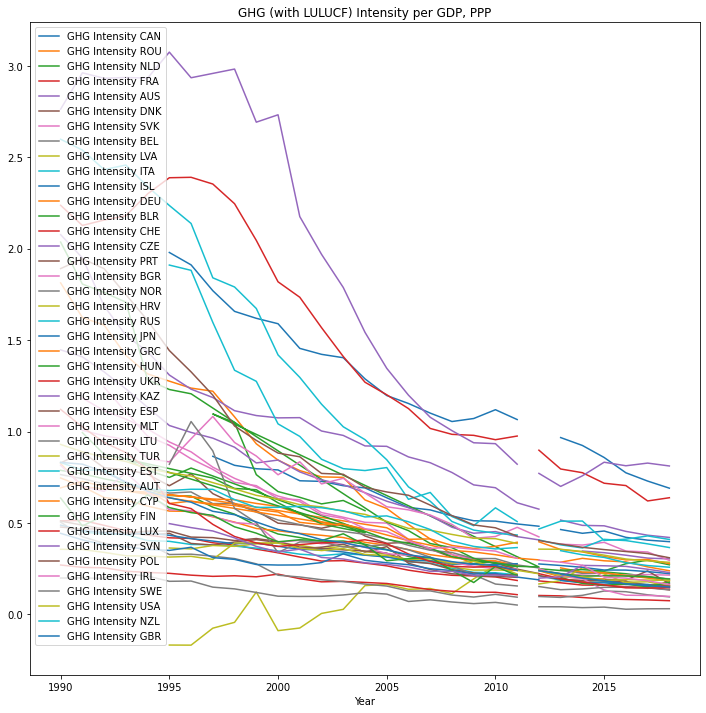

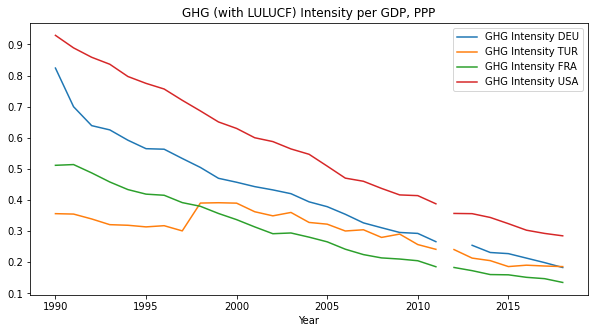

In [14]:
# save the list of countries 
df_cty= df_result[['country_iso_code','country_name']]
df_cty= df_cty.drop_duplicates()

# prepare the dictionary for the graph

ghg_intensity_with_lulucf = {"Year":  df_result['validity_date']}

for ind in df_cty.index:
     ghg_intensity_with_lulucf["GHG Intensity " + df_cty['country_iso_code'][ind]] = df_result[(df_result['country_iso_code']==df_cty['country_iso_code'][ind])]['ghg_intensity_with_lulucf_per_gdp']
        
             
plot.rcParams["figure.figsize"] = (12, 12)

df = pd.DataFrame(data=ghg_intensity_with_lulucf);

df.plot.line(x="Year", title="GHG (with LULUCF) Intensity per GDP, PPP");

plot.show(block=True);


# show only for DEU, FRA, USA, TUR

ghg_intensity_with_lulucf = {"Year":  df_result['validity_date'],
    
              "GHG Intensity DEU": df_result[(df_result['country_iso_code']=='DEU')]['ghg_intensity_with_lulucf_per_gdp'] ,
              
              "GHG Intensity TUR": df_result[(df_result['country_iso_code']=='TUR')]['ghg_intensity_with_lulucf_per_gdp'] ,                  
                             
              "GHG Intensity FRA": df_result[(df_result['country_iso_code']=='FRA')]['ghg_intensity_with_lulucf_per_gdp'] ,
              
              "GHG Intensity USA": df_result[(df_result['country_iso_code']=='USA')]['ghg_intensity_with_lulucf_per_gdp']                   
              };


#df = pd.DataFrame(data=ghg_intensity_without_lulucf);

plot.rcParams["figure.figsize"] = (10, 5)

df = pd.DataFrame(data=ghg_intensity_with_lulucf);

df.plot.line(x="Year", title="GHG (with LULUCF) Intensity per GDP, PPP");

plot.show(block=True);




<font size="5">Show the GHG intensity per GDP chart  (without LULUCF)</font>


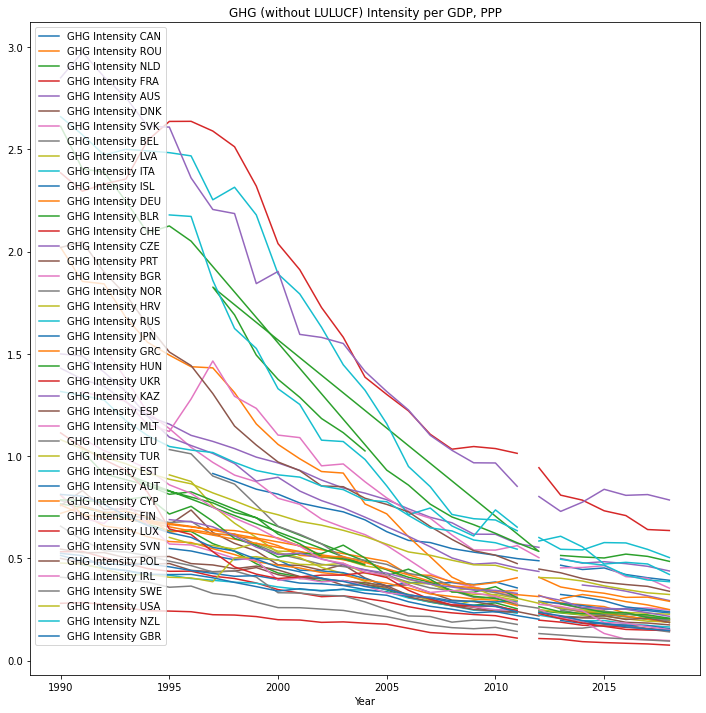

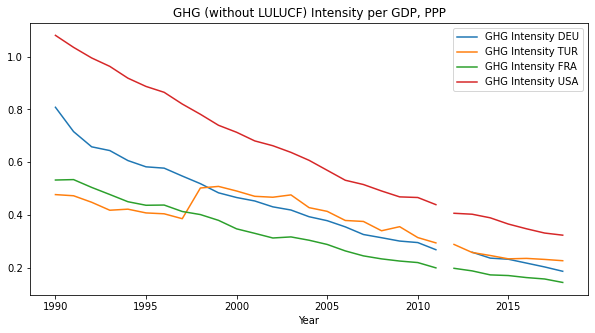

In [15]:
# prepare the dictionary for the graph

ghg_intensity_without_lulucf = {"Year":  df_result['validity_date']}

for ind in df_cty.index:
     ghg_intensity_without_lulucf["GHG Intensity " + df_cty['country_iso_code'][ind]] = df_result[(df_result['country_iso_code']==df_cty['country_iso_code'][ind])]['ghg_intensity_without_lulucf_per_gdp']
        
             
plot.rcParams["figure.figsize"] = (12, 12)

df = pd.DataFrame(data=ghg_intensity_without_lulucf);

df.plot.line(x="Year", title="GHG (without LULUCF) Intensity per GDP, PPP");

plot.show(block=True);


# show only for DEU, FRA, USA, TUR

ghg_intensity_without_lulucf = {"Year":  df_result['validity_date'],
    
              "GHG Intensity DEU": df_result[(df_result['country_iso_code']=='DEU')]['ghg_intensity_without_lulucf_per_gdp'] ,
              
              "GHG Intensity TUR": df_result[(df_result['country_iso_code']=='TUR')]['ghg_intensity_without_lulucf_per_gdp'] ,                  
                             
              "GHG Intensity FRA": df_result[(df_result['country_iso_code']=='FRA')]['ghg_intensity_without_lulucf_per_gdp'] ,
              
              "GHG Intensity USA": df_result[(df_result['country_iso_code']=='USA')]['ghg_intensity_without_lulucf_per_gdp']                   
              };


#df = pd.DataFrame(data=ghg_intensity_without_lulucf);

plot.rcParams["figure.figsize"] = (10, 5)

df = pd.DataFrame(data=ghg_intensity_without_lulucf);

df.plot.line(x="Year", title="GHG (without LULUCF) Intensity per GDP, PPP");

plot.show(block=True);



<font size="5">Save the results in Trino</font>


In [17]:
import osc_ingest_trino as osc
columnschema = osc.create_table_schema_pairs(df_result) 

sql = f"""
drop table if exists {ingest_catalog}.{ingest_schema}.{ingest_table}
"""
print(sql)
qres = engine.execute(sql)
print(qres.fetchall())



drop table if exists osc_datacommons_dev.sandbox.pcaf_unfcc_results

[(True,)]


In [18]:
tabledef = f"""
create table if not exists {ingest_catalog}.{ingest_schema}.{ingest_table}(
{columnschema}
) with (
    format = 'ORC',
    partitioning = array['country_iso_code']
)
"""
print(tabledef)
qres = engine.execute(tabledef)
print(qres.fetchall())


create table if not exists osc_datacommons_dev.sandbox.pcaf_unfcc_results(
    country_iso_code varchar,
    country_name varchar,
    validity_date bigint,
    ghg_total_with_lulucf double,
    ghg_unit varchar,
    ghg_total_without_lulucf double,
    gdp double,
    gdp_unit varchar,
    ghg_intensity_with_lulucf_per_gdp double,
    ghg_intensity_without_lulucf_per_gdp double,
    ghg_intensity_unit varchar
) with (
    format = 'ORC',
    partitioning = array['country_iso_code']
)

[(True,)]


In [19]:
# Delete all data from our db, so we start with empty table
sql=f"""
delete from {ingest_catalog}.{ingest_schema}.{ingest_table}
"""
qres = engine.execute(sql)
print(qres.fetchall())

[(None,)]


In [ ]:
sql=f"""
select * from {ingest_catalog}.{ingest_schema}.{ingest_table}
"""
pd.read_sql(sql, engine)


In [20]:
print(ingest_catalog)
#df=df.drop(df[df.country_name=="cote d'ivoire"].index)
df_result.to_sql(ingest_table,
           con=engine,
           schema=ingest_schema,
           if_exists='append',
           index=False,
           method=osc.TrinoBatchInsert(batch_size = 1000, verbose = True))

osc_datacommons_dev
constructed fully qualified table name as: "sandbox.pcaf_unfcc_results"
inserting 1000 records
  ('CAN', 'Canada', 1997, 652937.1624030604, 'kt CO₂ e', 691195.3671827108, 755390170461.408, 'current US$', 0.8643707423466112, 0.9150176878268278, 'kt CO₂ e/current US$')
  ('CAN', 'Canada', 1998, 647024.4222221853, 'kt CO₂ e', 696901.5185887723, 793674327704.288, 'current US$', 0.8152265981611259, 0.878069876097124, 'kt CO₂ e/current US$')
  ('CAN', 'Canada', 1999, 674254.6072188118, 'kt CO₂ e', 709600.924294885, 846412945809.995, 'current US$', 0.796602427404472, 0.8383625602699348, 'kt CO₂ e/current US$')
  ...
  ('HUN', 'Hungary', 1999, 75877.01478733166, 'kt CO₂ e', 77819.97959361807, 111315201192.571, 'current US$', 0.6816410874204625, 0.6990957098392385, 'kt CO₂ e/current US$')
batch insert result: [(1000,)]
inserting 149 records
  ('HUN', 'Hungary', 2000, 73859.33964413128, 'kt CO₂ e', 74916.73404619607, 121032462098.611, 'current US$', 0.610244048278176, 0.61898

In [21]:
sql=f"""
select * from {ingest_catalog}.{ingest_schema}.{ingest_table}"""
pd.read_sql(sql, engine)


,country_iso_code,country_name,validity_date,ghg_total_with_lulucf,ghg_unit,ghg_total_without_lulucf,gdp,gdp_unit,ghg_intensity_with_lulucf_per_gdp,ghg_intensity_without_lulucf_per_gdp,ghg_intensity_unit
0,SWE,Sweden,1990,34712.515074,kt CO₂ e,71239.174954,1.747211e+11,current US$,0.198674,0.407731,kt CO₂ e/current US$
1,SWE,Sweden,1991,35612.348228,kt CO₂ e,71495.940437,1.785597e+11,current US$,0.199442,0.400404,kt CO₂ e/current US$
2,SWE,Sweden,1992,35537.740599,kt CO₂ e,71032.917018,1.805130e+11,current US$,0.196871,0.393506,kt CO₂ e/current US$
3,SWE,Sweden,1993,39926.127693,kt CO₂ e,71336.933248,1.809747e+11,current US$,0.220617,0.394182,kt CO₂ e/current US$
4,SWE,Sweden,1994,40175.664625,kt CO₂ e,73852.013970,1.921034e+11,current US$,0.209136,0.384439,kt CO₂ e/current US$
...,...,...,...,...,...,...,...,...,...,...,...
1144,ISL,Iceland,2007,14220.119310,kt CO₂ e,4901.097531,1.291859e+10,current US$,1.100748,0.379383,kt CO₂ e/current US$
1145,ISL,Iceland,2008,14639.046235,kt CO₂ e,5299.940824,1.387992e+10,current US$,1.054693,0.381842,kt CO₂ e/current US$
1146,ISL,Iceland,2009,14282.701205,kt CO₂ e,4966.277617,1.333370e+10,current US$,1.071173,0.372461,kt CO₂ e/current US$
1147,ISL,Iceland,2010,14159.648165,kt CO₂ e,4866.265929,1.265018e+10,current US$,1.119324,0.384680,kt CO₂ e/current US$
